In [1]:
import matplotlib.pyplot as plt
import cmocean
import xarray as xr
import os
import matplotlib
matplotlib.rcParams["figure.dpi"] = 50

In [2]:
from xhistogram.xarray import histogram

In [3]:
proc_path = "../data/processed/NOAA_OISST_means.nc"
if not(os.path.isfile(proc_path)):
    raw_path = "../data/raw_observational_products/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr"
    ds_raw = xr.open_mfdataset(f"{avhrr_path}/*/*.nc")
    ds_raw = ds_raw.sel(time=slice('1982', '2023')) # pick out only full years

    ds = xr.Dataset()
    for v in ['sst', 'ice']:
        ds[f'{v}_mean'] = ds_raw[v].mean('time')
        ds[f'{v}_1982-1991_mean'] = ds_raw[v].sel(time=slice('1982', '1991')).mean('time')
        ds[f'{v}_2014-2023_mean'] = ds_raw[v].sel(time=slice('2014', '2023')).mean('time')
        ds[f'{v}_seasonal_climatology'] = ds_raw[v].groupby('time.season').mean('time')
    ds.to_netcdf()
    ds.close()

ds = xr.open_dataset(proc_path)

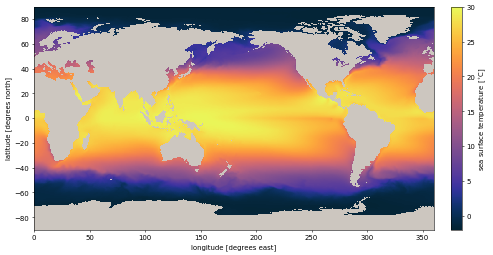

In [4]:
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ncols = 40
spec = gridspec.GridSpec(ncols=ncols, nrows=1, figure=fig, wspace=0.5)
ax = fig.add_subplot(spec[0, 0:ncols-3])
cax1 = fig.add_subplot(spec[0, ncols-2])
cax2 = fig.add_subplot(spec[0, ncols-1])

ax.set_facecolor((0.8, 0.775, 0.75))
pc_sst= ds['sst_mean'].plot(ax=ax, cmap=cmocean.cm.thermal, vmin=-2, vmax=30)
pc_sst.colorbar.remove()
cb_sst = plt.colorbar(pc_sst, cax=cax1)
cb_sst.set_label(r"sea surface temperature [$^{\circ}$C]")

pc_ice = (ds['ice_mean']*100).where(~(np.isnan(ds.ice_mean) | (ds.ice_mean < 0.1))).plot(ax=ax, cmap=cmocean.cm.ice, vmin=0, vmax=100)
pc_ice.colorbar.remove()
cb_ice = plt.colorbar(pc_ice, cax=cax2)
cb_ice.set_label("sea ice concentration [%]")

ax.set_xlabel("longitude [degrees east]")
ax.set_ylabel("latitude [degrees north]");
ax.set_title("")
fig.savefig("../figures/Lecture03_mean_sea_surface_temperature_pattern_OISST_with_ice.png", bbox_inches="tight", dpi=300)

cb_ice.remove()
pc_ice.remove()
fig.savefig("../figures/Lecture03_mean_sea_surface_temperature_pattern_OISST.png", bbox_inches="tight", dpi=300)

In [5]:
ds_woce = xr.open_dataset("../data/raw_observational_products/WGHC/wghc_params.nc")

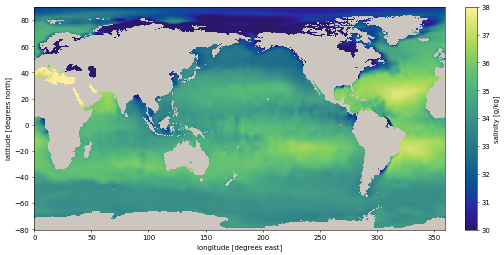

In [6]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(10, 5))
ax.set_facecolor((0.8, 0.775, 0.75))
pc = ds_woce['SALINITY'].sel(ZAX=0).plot(cmap=cmocean.cm.haline, vmin=0, vmax=40)
pc.colorbar.set_label("salinity [g/kg]")
plt.xlabel("longitude [degrees east]")
plt.ylabel("latitude [degrees north]")
plt.title("");
pc.set_clim(30, 38)
fig.savefig("../figures/Lecture03_mean_sea_surface_salinity_pattern_WOCE.png", bbox_inches="tight", dpi=300)

In [7]:
import numpy as np
TS_hist = histogram(
    ds_woce.SALINITY,
    ds_woce.TEMP,
    bins=[np.arange(-0.05, 50.1, 0.1), np.arange(-3, 40.1, 0.1)],
    block_size=None
).compute()

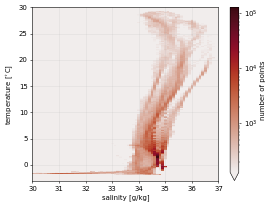

In [8]:
import matplotlib.colors as colors
lognormrange = 1e-3
fig = plt.figure(figsize=(6,4.5))
pc = TS_hist.where(TS_hist!=0, TS_hist.max()*lognormrange).plot(
    x="SALINITY_bin",
    y="TEMP_bin",
    norm=colors.LogNorm(vmin=TS_hist.max()*lognormrange, vmax=TS_hist.max()),
    cmap=cmocean.cm.amp
)
pc.colorbar.set_label("number of points")
plt.xlabel("salinity [g/kg]")
plt.ylabel(r"temperature [$^{\circ}$C]")
plt.xlim(30, 37)
plt.ylim(-3, 30)
plt.grid(True, alpha=0.25)
fig.savefig("../figures/Lecture03_TS_histogram_WOCE.png", bbox_inches="tight", dpi=300)